<a href="https://colab.research.google.com/github/jitendra77/StockWatchBoard/blob/main/JitenStockOptionValuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing with AAPL
Testing Option Valuation for AAPL
Current Stock Price: $205.17
Historical Volatility: 32.15%
Time to Expiry: 30 days
Risk-free Rate: 5.00%

CALL OPTIONS
--------------------
Strike Price: $215.43
Black-Scholes Price: $3.91
Binomial Price: $3.92
Price Difference: $0.01

Greeks:
  Delta: 0.3304
  Gamma: 0.0192
  Theta: -0.1230
  Vega: 0.2130
  Rho: 0.0525

PUT OPTIONS
--------------------
Strike Price: $194.91
Black-Scholes Price: $3.09
Binomial Price: $3.10
Price Difference: $0.00

Greeks:
  Delta: -0.2587
  Gamma: 0.0171
  Theta: -0.0943
  Vega: 0.1902
  Rho: -0.0461


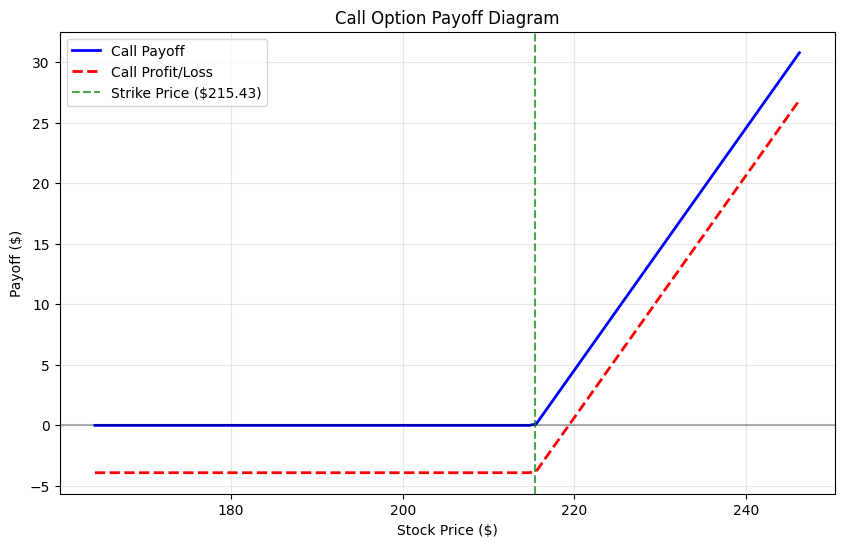

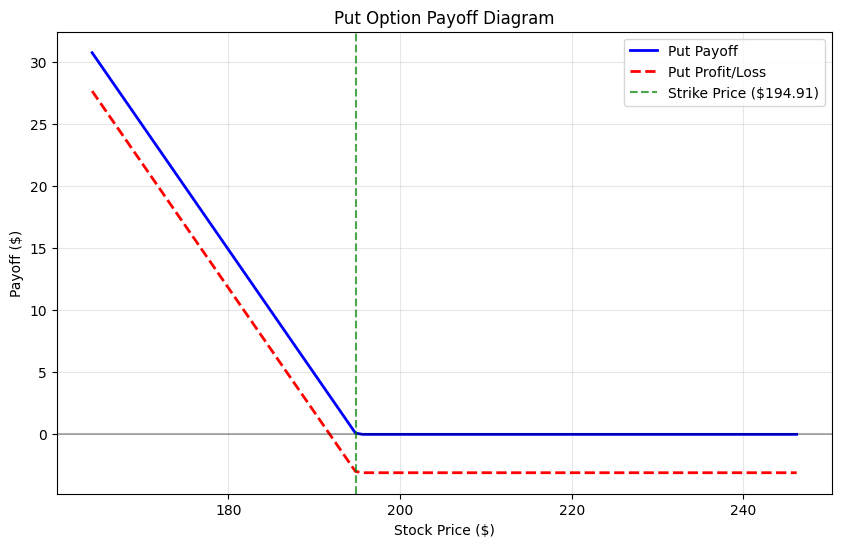

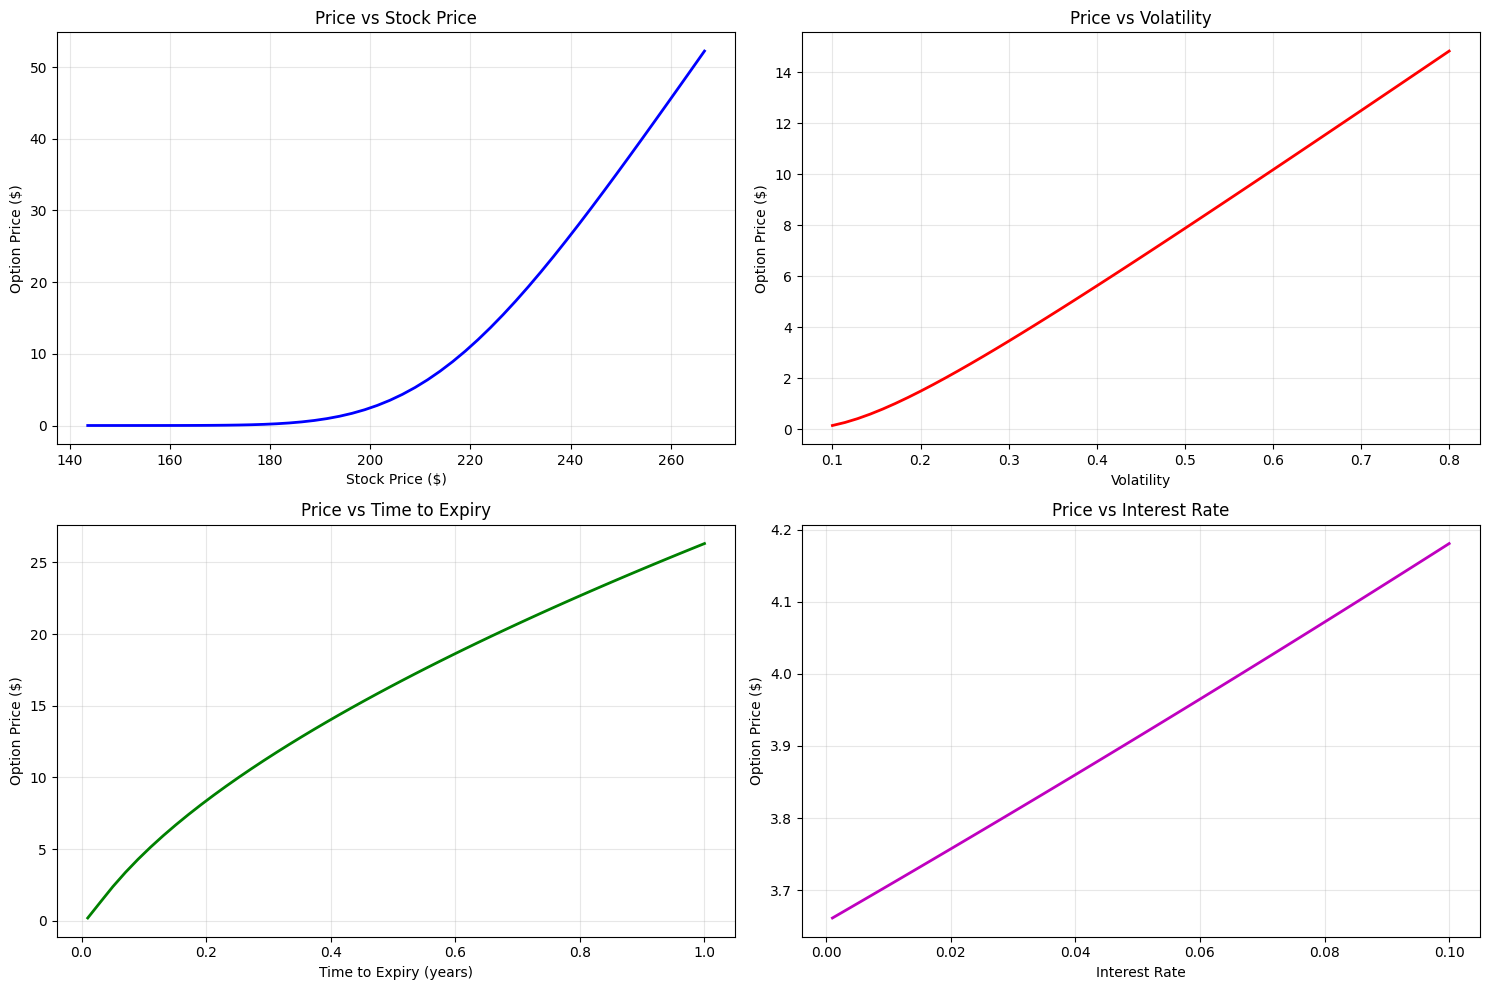

In [1]:
# Stock Option Valuation in Google Colab
# Copy and paste this code into Google Colab cells

# Cell 1: Install required packages
!pip install yfinance numpy scipy matplotlib pandas

# Cell 2: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Cell 3: Black-Scholes Option Pricing Model
class BlackScholes:
    def __init__(self, S, K, T, r, sigma, option_type='call'):
        """
        S: Current stock price
        K: Strike price
        T: Time to expiration (in years)
        r: Risk-free rate
        sigma: Volatility
        option_type: 'call' or 'put'
        """
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.option_type = option_type.lower()

    def d1(self):
        return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))

    def d2(self):
        return self.d1() - self.sigma * np.sqrt(self.T)

    def price(self):
        d1 = self.d1()
        d2 = self.d2()

        if self.option_type == 'call':
            price = (self.S * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2))
        else:  # put
            price = (self.K * np.exp(-self.r * self.T) * norm.cdf(-d2) - self.S * norm.cdf(-d1))

        return price

    def greeks(self):
        d1 = self.d1()
        d2 = self.d2()

        # Delta
        if self.option_type == 'call':
            delta = norm.cdf(d1)
        else:
            delta = -norm.cdf(-d1)

        # Gamma
        gamma = norm.pdf(d1) / (self.S * self.sigma * np.sqrt(self.T))

        # Theta
        if self.option_type == 'call':
            theta = (-(self.S * norm.pdf(d1) * self.sigma) / (2 * np.sqrt(self.T))
                    - self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(d2)) / 365
        else:
            theta = (-(self.S * norm.pdf(d1) * self.sigma) / (2 * np.sqrt(self.T))
                    + self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-d2)) / 365

        # Vega
        vega = self.S * norm.pdf(d1) * np.sqrt(self.T) / 100

        # Rho
        if self.option_type == 'call':
            rho = self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(d2) / 100
        else:
            rho = -self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-d2) / 100

        return {
            'delta': delta,
            'gamma': gamma,
            'theta': theta,
            'vega': vega,
            'rho': rho
        }

# Cell 4: Binomial Option Pricing Model
class BinomialOption:
    def __init__(self, S, K, T, r, sigma, n=100, option_type='call', american=False):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.n = n  # number of steps
        self.option_type = option_type.lower()
        self.american = american

        # Calculate parameters
        self.dt = T / n
        self.u = np.exp(sigma * np.sqrt(self.dt))
        self.d = 1 / self.u
        self.p = (np.exp(r * self.dt) - self.d) / (self.u - self.d)

    def price(self):
        # Initialize stock price tree
        stock_tree = np.zeros((self.n + 1, self.n + 1))
        for i in range(self.n + 1):
            for j in range(i + 1):
                stock_tree[j, i] = self.S * (self.u ** (i - j)) * (self.d ** j)

        # Initialize option price tree
        option_tree = np.zeros((self.n + 1, self.n + 1))

        # Calculate option values at expiration
        for j in range(self.n + 1):
            if self.option_type == 'call':
                option_tree[j, self.n] = max(0, stock_tree[j, self.n] - self.K)
            else:
                option_tree[j, self.n] = max(0, self.K - stock_tree[j, self.n])

        # Work backwards through the tree
        for i in range(self.n - 1, -1, -1):
            for j in range(i + 1):
                # European option value
                option_tree[j, i] = (self.p * option_tree[j, i + 1] +
                                   (1 - self.p) * option_tree[j + 1, i + 1]) * np.exp(-self.r * self.dt)

                # American option early exercise check
                if self.american:
                    if self.option_type == 'call':
                        option_tree[j, i] = max(option_tree[j, i], stock_tree[j, i] - self.K)
                    else:
                        option_tree[j, i] = max(option_tree[j, i], self.K - stock_tree[j, i])

        return option_tree[0, 0]

# Cell 5: Get real market data and calculate historical volatility
def get_stock_data(symbol, period='1y'):
    """Get stock data and calculate historical volatility"""
    try:
        stock = yf.Ticker(symbol)
        hist = stock.history(period=period)

        # Calculate daily returns
        returns = hist['Close'].pct_change().dropna()

        # Calculate annualized volatility
        volatility = returns.std() * np.sqrt(252)  # 252 trading days in a year

        current_price = hist['Close'][-1]

        return current_price, volatility, hist
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None, None, None

# Cell 6: Test the models with real data
def test_option_valuation(symbol='AAPL', strike_offset=0.05, days_to_expiry=30):
    """
    Test option valuation with real market data
    symbol: Stock ticker
    strike_offset: Strike price as percentage above/below current price
    days_to_expiry: Days until option expiration
    """
    print(f"Testing Option Valuation for {symbol}")
    print("=" * 50)

    # Get market data
    current_price, volatility, hist_data = get_stock_data(symbol)

    if current_price is None:
        print("Failed to get market data")
        return

    # Option parameters
    S = current_price
    K_call = S * (1 + strike_offset)  # Call strike above current price
    K_put = S * (1 - strike_offset)   # Put strike below current price
    T = days_to_expiry / 365.25
    r = 0.05  # Risk-free rate (approximate)
    sigma = volatility

    print(f"Current Stock Price: ${S:.2f}")
    print(f"Historical Volatility: {sigma:.2%}")
    print(f"Time to Expiry: {days_to_expiry} days")
    print(f"Risk-free Rate: {r:.2%}")
    print()

    # Test Call Options
    print("CALL OPTIONS")
    print("-" * 20)
    print(f"Strike Price: ${K_call:.2f}")

    # Black-Scholes Call
    bs_call = BlackScholes(S, K_call, T, r, sigma, 'call')
    bs_call_price = bs_call.price()
    bs_call_greeks = bs_call.greeks()

    # Binomial Call
    bin_call = BinomialOption(S, K_call, T, r, sigma, n=100, option_type='call')
    bin_call_price = bin_call.price()

    print(f"Black-Scholes Price: ${bs_call_price:.2f}")
    print(f"Binomial Price: ${bin_call_price:.2f}")
    print(f"Price Difference: ${abs(bs_call_price - bin_call_price):.2f}")
    print()
    print("Greeks:")
    for greek, value in bs_call_greeks.items():
        print(f"  {greek.capitalize()}: {value:.4f}")

    print()

    # Test Put Options
    print("PUT OPTIONS")
    print("-" * 20)
    print(f"Strike Price: ${K_put:.2f}")

    # Black-Scholes Put
    bs_put = BlackScholes(S, K_put, T, r, sigma, 'put')
    bs_put_price = bs_put.price()
    bs_put_greeks = bs_put.greeks()

    # Binomial Put
    bin_put = BinomialOption(S, K_put, T, r, sigma, n=100, option_type='put')
    bin_put_price = bin_put.price()

    print(f"Black-Scholes Price: ${bs_put_price:.2f}")
    print(f"Binomial Price: ${bin_put_price:.2f}")
    print(f"Price Difference: ${abs(bs_put_price - bin_put_price):.2f}")
    print()
    print("Greeks:")
    for greek, value in bs_put_greeks.items():
        print(f"  {greek.capitalize()}: {value:.4f}")

    return {
        'stock_data': hist_data,
        'current_price': S,
        'volatility': sigma,
        'call_bs': bs_call_price,
        'call_bin': bin_call_price,
        'put_bs': bs_put_price,
        'put_bin': bin_put_price,
        'call_greeks': bs_call_greeks,
        'put_greeks': bs_put_greeks
    }

# Cell 7: Visualization functions
def plot_option_payoff(S_range, K, option_type='call', option_price=None):
    """Plot option payoff diagram"""
    if option_type == 'call':
        payoff = np.maximum(S_range - K, 0)
        if option_price:
            profit = payoff - option_price
    else:
        payoff = np.maximum(K - S_range, 0)
        if option_price:
            profit = payoff - option_price

    plt.figure(figsize=(10, 6))
    plt.plot(S_range, payoff, 'b-', linewidth=2, label=f'{option_type.capitalize()} Payoff')

    if option_price:
        plt.plot(S_range, profit, 'r--', linewidth=2, label=f'{option_type.capitalize()} Profit/Loss')
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    plt.axvline(x=K, color='g', linestyle='--', alpha=0.7, label=f'Strike Price (${K:.2f})')
    plt.xlabel('Stock Price ($)')
    plt.ylabel('Payoff ($)')
    plt.title(f'{option_type.capitalize()} Option Payoff Diagram')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_price_sensitivity(S_base, K, T, r, sigma, option_type='call'):
    """Plot option price sensitivity to various parameters"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Price sensitivity to stock price
    S_range = np.linspace(S_base * 0.7, S_base * 1.3, 50)
    prices = [BlackScholes(S, K, T, r, sigma, option_type).price() for S in S_range]
    axes[0, 0].plot(S_range, prices, 'b-', linewidth=2)
    axes[0, 0].set_title('Price vs Stock Price')
    axes[0, 0].set_xlabel('Stock Price ($)')
    axes[0, 0].set_ylabel('Option Price ($)')
    axes[0, 0].grid(True, alpha=0.3)

    # Price sensitivity to volatility
    vol_range = np.linspace(0.1, 0.8, 50)
    prices = [BlackScholes(S_base, K, T, r, vol, option_type).price() for vol in vol_range]
    axes[0, 1].plot(vol_range, prices, 'r-', linewidth=2)
    axes[0, 1].set_title('Price vs Volatility')
    axes[0, 1].set_xlabel('Volatility')
    axes[0, 1].set_ylabel('Option Price ($)')
    axes[0, 1].grid(True, alpha=0.3)

    # Price sensitivity to time
    time_range = np.linspace(0.01, 1, 50)
    prices = [BlackScholes(S_base, K, t, r, sigma, option_type).price() for t in time_range]
    axes[1, 0].plot(time_range, prices, 'g-', linewidth=2)
    axes[1, 0].set_title('Price vs Time to Expiry')
    axes[1, 0].set_xlabel('Time to Expiry (years)')
    axes[1, 0].set_ylabel('Option Price ($)')
    axes[1, 0].grid(True, alpha=0.3)

    # Price sensitivity to interest rate
    rate_range = np.linspace(0.001, 0.1, 50)
    prices = [BlackScholes(S_base, K, T, rate, sigma, option_type).price() for rate in rate_range]
    axes[1, 1].plot(rate_range, prices, 'm-', linewidth=2)
    axes[1, 1].set_title('Price vs Interest Rate')
    axes[1, 1].set_xlabel('Interest Rate')
    axes[1, 1].set_ylabel('Option Price ($)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Cell 8: Run the tests
if __name__ == "__main__":
    # Test with Apple stock
    print("Testing with AAPL")
    results_aapl = test_option_valuation('AAPL', strike_offset=0.05, days_to_expiry=30)

    if results_aapl:
        # Plot payoff diagrams
        S_range = np.linspace(results_aapl['current_price'] * 0.8,
                             results_aapl['current_price'] * 1.2, 100)

        # Call option payoff
        K_call = results_aapl['current_price'] * 1.05
        plot_option_payoff(S_range, K_call, 'call', results_aapl['call_bs'])

        # Put option payoff
        K_put = results_aapl['current_price'] * 0.95
        plot_option_payoff(S_range, K_put, 'put', results_aapl['put_bs'])

        # Price sensitivity analysis
        plot_price_sensitivity(results_aapl['current_price'], K_call, 30/365.25,
                             0.05, results_aapl['volatility'], 'call')

# Cell 9: Interactive testing function
def interactive_option_test():
    """Interactive function to test different scenarios"""
    print("Interactive Option Valuation Tool")
    print("=" * 40)

    # Get user inputs
    symbol = input("Enter stock symbol (e.g., AAPL, MSFT, GOOGL): ").upper()

    try:
        strike_offset = float(input("Enter strike offset (e.g., 0.05 for 5% OTM): "))
        days = int(input("Enter days to expiration: "))
        option_type = input("Enter option type (call/put): ").lower()
    except ValueError:
        print("Invalid input. Using default values.")
        strike_offset = 0.05
        days = 30
        option_type = 'call'

    # Run the test
    current_price, volatility, _ = get_stock_data(symbol)

    if current_price is None:
        print(f"Could not fetch data for {symbol}")
        return

    if option_type == 'call':
        K = current_price * (1 + strike_offset)
    else:
        K = current_price * (1 - strike_offset)

    T = days / 365.25
    r = 0.05

    # Calculate option price
    bs_option = BlackScholes(current_price, K, T, r, volatility, option_type)
    price = bs_option.price()
    greeks = bs_option.greeks()

    print(f"\nResults for {symbol} {option_type.upper()}")
    print(f"Current Price: ${current_price:.2f}")
    print(f"Strike Price: ${K:.2f}")
    print(f"Option Price: ${price:.2f}")
    print(f"Implied Volatility: {volatility:.2%}")
    print("\nGreeks:")
    for greek, value in greeks.items():
        print(f"  {greek.capitalize()}: {value:.4f}")

# Cell 10: Portfolio analysis
def portfolio_analysis():
    """Analyze a portfolio of options"""
    print("Option Portfolio Analysis")
    print("=" * 30)

    # Example portfolio
    portfolio = [
        {'symbol': 'AAPL', 'option_type': 'call', 'strike_offset': 0.05, 'days': 30, 'quantity': 10},
        {'symbol': 'AAPL', 'option_type': 'put', 'strike_offset': 0.05, 'days': 30, 'quantity': -5},
        {'symbol': 'MSFT', 'option_type': 'call', 'strike_offset': 0.03, 'days': 45, 'quantity': 5},
    ]

    total_value = 0
    total_delta = 0
    total_gamma = 0
    total_theta = 0
    total_vega = 0

    print("Portfolio Positions:")
    print("-" * 60)

    for position in portfolio:
        current_price, volatility, _ = get_stock_data(position['symbol'])

        if current_price is None:
            continue

        if position['option_type'] == 'call':
            K = current_price * (1 + position['strike_offset'])
        else:
            K = current_price * (1 - position['strike_offset'])

        T = position['days'] / 365.25
        r = 0.05

        option = BlackScholes(current_price, K, T, r, volatility, position['option_type'])
        price = option.price()
        greeks = option.greeks()

        position_value = price * position['quantity'] * 100  # Options are per 100 shares

        total_value += position_value
        total_delta += greeks['delta'] * position['quantity']
        total_gamma += greeks['gamma'] * position['quantity']
        total_theta += greeks['theta'] * position['quantity']
        total_vega += greeks['vega'] * position['quantity']

        print(f"{position['symbol']} {position['option_type'].upper()} "
              f"${K:.2f} {position['days']}D x{position['quantity']}: "
              f"${position_value:,.2f}")

    print("-" * 60)
    print(f"Total Portfolio Value: ${total_value:,.2f}")
    print(f"Portfolio Greeks:")
    print(f"  Delta: {total_delta:.2f}")
    print(f"  Gamma: {total_gamma:.2f}")
    print(f"  Theta: ${total_theta:.2f}/day")
    print(f"  Vega: {total_vega:.2f}")

# Call the interactive function
# Uncomment the line below to run interactively
# interactive_option_test()

# Call portfolio analysis
# portfolio_analysis()

In [2]:
results = test_option_valuation('NVDA', strike_offset=0.10, days_to_expiry=45)

Testing Option Valuation for NVDA
Current Stock Price: $157.99
Historical Volatility: 57.70%
Time to Expiry: 45 days
Risk-free Rate: 5.00%

CALL OPTIONS
--------------------
Strike Price: $173.79
Black-Scholes Price: $7.24
Binomial Price: $7.26
Price Difference: $0.02

Greeks:
  Delta: 0.3673
  Gamma: 0.0118
  Theta: -0.1410
  Vega: 0.2089
  Rho: 0.0626

PUT OPTIONS
--------------------
Strike Price: $142.19
Black-Scholes Price: $5.51
Binomial Price: $5.53
Price Difference: $0.02

Greeks:
  Delta: -0.2572
  Gamma: 0.0101
  Theta: -0.1084
  Vega: 0.1789
  Rho: -0.0569


In [3]:
interactive_option_test()

Interactive Option Valuation Tool
Enter stock symbol (e.g., AAPL, MSFT, GOOGL): GOOGL
Enter strike offset (e.g., 0.05 for 5% OTM): .05
Enter days to expiration: 30
Enter option type (call/put): CALL

Results for GOOGL CALL
Current Price: $176.23
Strike Price: $185.04
Option Price: $3.35
Implied Volatility: 32.09%

Greeks:
  Delta: 0.3300
  Gamma: 0.0223
  Theta: -0.1054
  Vega: 0.1829
  Rho: 0.0450


# New Section